# 基于Caltech数据集的图像分类


## 配置环境

### 上传数据

In [ ]:
# !pwd

/content


In [ ]:
# !mkdir data

In [11]:
# !mkdir data/process

In [ ]:
# !cp ./drive/MyDrive/dataset.zip ./data/

In [ ]:
# !unzip /content/data/dataset.zip

In [13]:
# !mv dataset ./data/

In [ ]:
# !unzip demo1.zip

Archive:  demo1.zip
   creating: utils/
  inflating: utils/datasets.py       
  inflating: utils/data_prepare.py   
   creating: utils/__pycache__/
  inflating: utils/__pycache__/datasets.cpython-39.pyc  
  inflating: utils/__pycache__/data_prepare.cpython-39.pyc  
  inflating: label_distribution.png  


In [ ]:
# !rm -rf demo1.zip

In [14]:
# !rm -rf /content/data/dataset.zip

### 安装包

In [8]:
!pip install torchinfo

## 数据处理

In [15]:
from utils.data_prepare import get_data_list
get_data_list()

## Resnet50

### data

In [31]:
from utils.data_prepare import load_class_list
class_list = load_class_list()
len(class_list)

102

In [32]:
from utils.datasets import get_dataloader
train_loader, val_loader = get_dataloader(64)

for i_batch, sample_batched in enumerate(train_loader):
    print("batch: ", i_batch)
    print("img.shape: ", sample_batched[0].shape)
    print("label.shape: ", sample_batched[1].shape)
    break

batch:  0
img.shape:  torch.Size([64, 3, 224, 224])
label.shape:  torch.Size([64])


### model

In [33]:
import torchvision.models as models

resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

In [34]:
import torch.nn as nn
resnet50.fc = nn.Linear(2048,102)
nn.init.xavier_normal_(resnet50.fc.weight)

Parameter containing:
tensor([[-0.0476,  0.0005, -0.0188,  ..., -0.0137, -0.0067, -0.0129],
        [-0.0037, -0.0049,  0.0122,  ...,  0.0172,  0.0311,  0.0394],
        [-0.0092,  0.0082,  0.0447,  ..., -0.0186, -0.0694,  0.0316],
        ...,
        [-0.0224, -0.0174, -0.0210,  ...,  0.0006,  0.0104, -0.0331],
        [-0.0652,  0.0068,  0.0088,  ...,  0.0455, -0.0460, -0.0453],
        [ 0.0372,  0.0093, -0.0437,  ...,  0.0167,  0.0953,  0.0121]],
       requires_grad=True)

In [35]:
for param in resnet50.parameters():
    param.requires_grad = False

for param in resnet50.fc.parameters():
    param.requires_grad = True

In [36]:
from torchinfo import summary
summary(resnet50, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 102]                  --
├─Conv2d: 1-1                            [1, 64, 112, 112]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         (128)
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           (4,096)
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]    

## Train

In [37]:
import torch

def score(model, dataloader, device):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            y_pred.extend(torch.argmax(out, dim=-1).tolist())
            y_true.extend(y.tolist())
    accuracy = sum([1 if y_true[i] == y_pred[i] else 0 for i in range(len(y_true))]) / len(y_true)
    return accuracy

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [40]:
num_epochs = 20
for epoch in range(num_epochs):
    # Train
    for i, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)

        outputs = resnet50(data)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        if i % 20 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

    # Evaluate
    train_acc = score(resnet50, train_loader, device)
    val_acc = score(resnet50, val_loader, device)
    print("Epoch [{}/{}], Train Acc: {:.4f}, Val Acc: {:.4f}".format(epoch+1, num_epochs, train_acc, val_acc))

    # Save the model checkpoint
    if (epoch+1) % 2 == 0:
        torch.save(resnet50.state_dict(), 'resnet50_epoch{}.pth'.format(epoch+1))

    # Decay learning rate
    scheduler.step()

Epoch [1/20], Step [1/113], Loss: 4.6180
Epoch [1/20], Step [21/113], Loss: 2.2006
Epoch [1/20], Step [41/113], Loss: 1.3069
Epoch [1/20], Step [61/113], Loss: 1.0032
Epoch [1/20], Step [81/113], Loss: 0.5128
Epoch [1/20], Step [101/113], Loss: 0.6794
Epoch [1/20], Train Acc: 0.9347, Val Acc: 0.8762
Epoch [2/20], Step [1/113], Loss: 0.3520
Epoch [2/20], Step [21/113], Loss: 0.3035
Epoch [2/20], Step [41/113], Loss: 0.3684
Epoch [2/20], Step [61/113], Loss: 0.4011
Epoch [2/20], Step [81/113], Loss: 0.1931
Epoch [2/20], Step [101/113], Loss: 0.1763
Epoch [2/20], Train Acc: 0.9600, Val Acc: 0.8900
Epoch [3/20], Step [1/113], Loss: 0.1002
Epoch [3/20], Step [21/113], Loss: 0.2042
Epoch [3/20], Step [41/113], Loss: 0.1919
Epoch [3/20], Step [61/113], Loss: 0.0728
Epoch [3/20], Step [81/113], Loss: 0.1228
Epoch [3/20], Step [101/113], Loss: 0.0835
Epoch [3/20], Train Acc: 0.9735, Val Acc: 0.8925
Epoch [4/20], Step [1/113], Loss: 0.1021
Epoch [4/20], Step [21/113], Loss: 0.1856
Epoch [4/20], 

## submit

### data

In [41]:
import torchvision.transforms as transforms
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class TestCaltechDataset(Dataset):
    """Caltech 101 dataset."""

    def __init__(self, root_dir, data_path, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.data_path = data_path
        self.transform = transform

        # Load the data
        self.img_paths = []
        self.load_data()

    def load_data(self):
        """
        Load the data from the root directory.
        """

        with open(self.data_path, "r", encoding="utf-8") as f:
            self.info = f.readlines()
        for img_info in self.info:
            img_path = img_info.strip()
            self.img_paths.append(img_path)


    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(os.path.join(self.root_dir, img_path)).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image


def get_test_dataloader(batch_size = 32, shuffle=False):
    """
    Get train and val dataloader of Caltech 101 dataset.
    """

    transform_test=transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    ])

    test_dataset = TestCaltechDataset(
        root_dir = './data/dataset/images',
        data_path = './data/dataset/test.txt',
        transform = transform_test
    )

    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

    return test_dataloader, test_dataset

In [42]:
test_loader, test_dataset = get_test_dataloader()

In [43]:
print('=============test_loader =============')
for data in test_loader:
    print(data)
    print(data.shape)
    break

=============test_loader =============
tensor([[[[-1.0904, -0.8507, -0.8164,  ..., -1.8782, -1.8782, -1.8439],
          [-0.6281, -0.4054, -0.5424,  ..., -1.8782, -1.8782, -1.8097],
          [ 0.7077,  0.2453, -0.7822,  ..., -1.6555, -1.6384, -1.5870],
          ...,
          [-1.7925, -1.7069, -1.6042,  ..., -0.7479, -0.7650, -0.8678],
          [-1.7583, -1.7583, -1.6898,  ..., -0.7993, -1.1247, -1.2617],
          [-1.6042, -1.7583, -1.7754,  ..., -1.2788, -1.2103, -1.1418]],

         [[-0.7052, -0.4601, -0.4776,  ..., -1.6681, -1.6681, -1.6506],
          [-0.2150, -0.0049, -0.1800,  ..., -1.7031, -1.6681, -1.6331],
          [ 1.1331,  0.6779, -0.4076,  ..., -1.5280, -1.4580, -1.4405],
          ...,
          [-1.7381, -1.6506, -1.5805,  ..., -0.8627, -0.8803, -1.0028],
          [-1.7381, -1.7381, -1.6681,  ..., -0.9153, -1.2479, -1.4055],
          [-1.6155, -1.7731, -1.7906,  ..., -1.3704, -1.3179, -1.2479]],

         [[-0.6890, -0.4275, -0.3753,  ..., -1.5604, -1.5604, -

### predict

In [44]:
resnet50.load_state_dict(torch.load('resnet50_epoch8.pth'))

<All keys matched successfully>

In [45]:
# 将预测结果写入列表中
pred_list = []
resnet50.eval()
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        output = resnet50(data)
        pred_list.extend(output.argmax(dim=-1).tolist())

In [46]:
len(test_dataset.img_paths)

1145

In [47]:
len(pred_list)

1145

In [52]:
with open('./data/result.txt', 'w', encoding='utf-8') as f_result:
    for i, pred in enumerate(pred_list):
        f_result.write(test_dataset.img_paths[i] + '\t' + str(pred) + '\n')

### Take a look

In [53]:
with open('./data/result.txt', 'r', encoding='utf-8') as f_result:
  res = f_result.readlines()

In [54]:
len(res)

1145

5284.jpg is soccer_ball


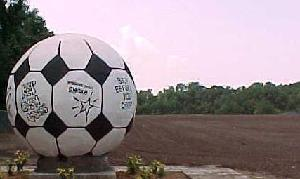

In [59]:
idx = 5
root_dir = './data/dataset/images'
img_path, label = res[idx].strip().split("\t")
print(f"{img_path} is {class_list[eval(label)]}")
Image.open(os.path.join(root_dir, img_path)).convert('RGB')